## COMBINED DENSENET AND LSTM ARCHITECTURE


Found 1604 images belonging to 20 classes.
Found 396 images belonging to 20 classes.
Found 2505 images belonging to 20 classes.


1/1 [==============================] - 0s 481ms/step
Epoch 1/120


51/51 [==============================] - 5s 28ms/step - loss: 2.9602 - accuracy: 0.1340 - val_loss: 2.8988 - val_accuracy: 0.1389
Epoch 2/120
51/51 [==============================] - 0s 9ms/step - loss: 2.8840 - accuracy: 0.1378 - val_loss: 2.8273 - val_accuracy: 0.1389
Epoch 3/120
51/51 [==============================] - 1s 10ms/step - loss: 2.7865 - accuracy: 0.1540 - val_loss: 2.6977 - val_accuracy: 0.1768
Epoch 4/120
51/51 [==============================] - 1s 10ms/step - loss: 2.5331 - accuracy: 0.2357 - val_loss: 2.2874 - val_accuracy: 0.3005
Epoch 5/120
51/51 [==============================] - 1s 10ms/step - loss: 2.1140 - accuracy: 0.3086 - val_loss: 2.0593 - val_accuracy: 0.2929
Epoch 6/120
51/51 [==============================] - 1s 10ms/step - loss: 1.9219 - accuracy: 0.3460 - val

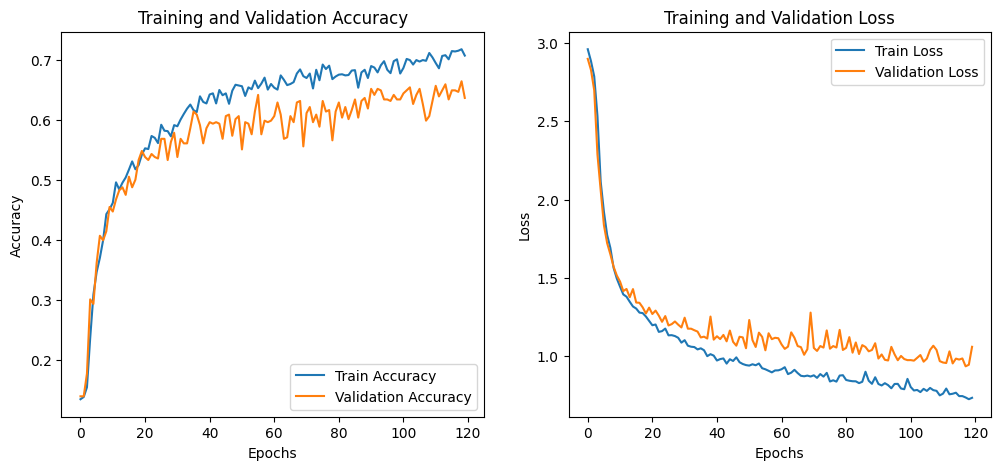

79/79 [==============================] - 1s 3ms/step


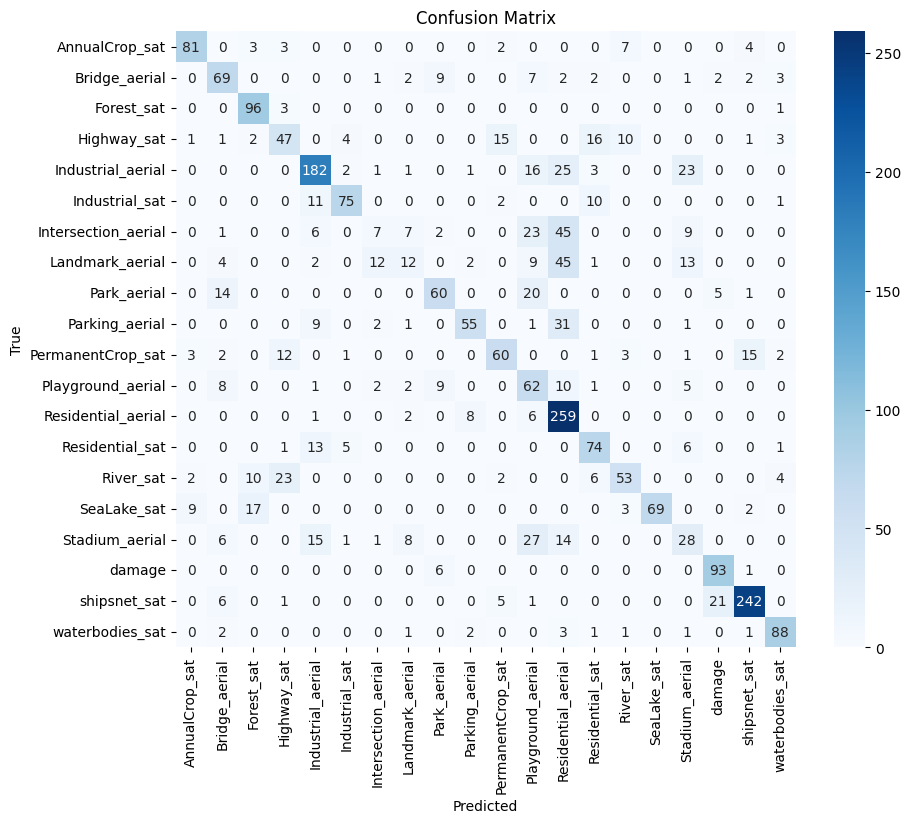

Classification Report:
                     precision    recall  f1-score   support

     AnnualCrop_sat       0.84      0.81      0.83       100
      Bridge_aerial       0.61      0.69      0.65       100
         Forest_sat       0.75      0.96      0.84       100
        Highway_sat       0.52      0.47      0.49       100
  Industrial_aerial       0.76      0.72      0.74       254
     Industrial_sat       0.85      0.76      0.80        99
Intersection_aerial       0.27      0.07      0.11       100
    Landmark_aerial       0.33      0.12      0.18       100
        Park_aerial       0.70      0.60      0.65       100
     Parking_aerial       0.81      0.55      0.65       100
  PermanentCrop_sat       0.70      0.60      0.65       100
  Playground_aerial       0.36      0.62      0.46       100
 Residential_aerial       0.60      0.94      0.73       276
    Residential_sat       0.64      0.74      0.69       100
          River_sat       0.69      0.53      0.60       100


In [1]:
import os
import numpy as np
import tensorflow as tf
import keras.backend as K

import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, BatchNormalization, ReLU, Conv2D, MaxPool2D, GlobalAvgPool2D, Concatenate, Input, AvgPool2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

# Set dataset paths
dataset_path = "DATASET"
train_path = os.path.join(dataset_path, "TRAIN")
test_path = os.path.join(dataset_path, "TEST")

# Image settings
img_size = (224, 224)
batch_size = 32

# Image Data Generator
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    train_path, target_size=img_size, batch_size=batch_size, class_mode='categorical', subset='training')
val_generator = train_datagen.flow_from_directory(
    train_path, target_size=img_size, batch_size=batch_size, class_mode='categorical', subset='validation')
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_path, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

num_classes = len(train_generator.class_indices)

# DenseNet Feature Extractor
def densenet_feature_extractor(img_shape, f=32):
    repetitions = [6, 12, 24, 16]
    
    def bn_rl_conv(x, f, k=1, s=1, p='same'):
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(f, k, strides=s, padding=p)(x)
        return x
    
    def dense_block(tensor, r):
        for _ in range(r):
            x = bn_rl_conv(tensor, 4*f)
            x = bn_rl_conv(x, f, 3)
            tensor = Concatenate()([tensor, x])
        return tensor
    
    def transition_block(x):
        x = bn_rl_conv(x, K.int_shape(x)[-1] // 2)
        x = AvgPool2D(2, strides=2, padding='same')(x)
        return x
    
    input_layer = Input(img_shape)
    x = Conv2D(64, 7, strides=2, padding='same')(input_layer)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    for r in repetitions:
        d = dense_block(x, r)
        x = transition_block(d)
    
    x = GlobalAvgPool2D()(d)
    model = Model(input_layer, x)
    return model

# Create DenseNet feature extractor
densenet_model = densenet_feature_extractor((224, 224, 3))
densenet_model.trainable = False

# Function to extract features
def extract_features(generator, feature_extractor):
    features, labels = [], []
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        x_features = feature_extractor.predict(x_batch)
        features.append(x_features)
        labels.append(y_batch)
        if len(features) * batch_size >= generator.samples:
            break
    return np.vstack(features), np.vstack(labels)

# Extract features for train, validation, and test data
X_train, y_train = extract_features(train_generator, densenet_model)
X_val, y_val = extract_features(val_generator, densenet_model)
X_test, y_test = extract_features(test_generator, densenet_model)

# Reshape for LSTM input
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Define LSTM model
lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile model
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = lstm_model.fit(X_train, y_train, epochs=120, batch_size=batch_size, validation_data=(X_val, y_val))

# Evaluate model
test_loss, test_acc = lstm_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Predict and Confusion Matrix
y_pred = lstm_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=train_generator.class_indices.keys()))